# Louis George    

## EDA of Scraped Script and Score Data

In [47]:
import numpy as np
import pandas as pd

import re
import json
import spacy

import matplotlib.pyplot as plt
%matplotlib inline

Reading in, and inspection of the script file:

In [16]:
df = pd.read_csv('../../data/scripts_upto_all.csv', index_col='Unnamed: 0')

In [17]:
df.head(2)

,titles,scripts,genres
0,10 Things I Hate About You,TEN THINGS I HA...,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1,12,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...,"['Action', 'Adventure', 'Animation', 'Comedy',..."


In [18]:
df.shape

(1210, 3)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 0 to 1209
Data columns (total 3 columns):
titles     1210 non-null object
scripts    1145 non-null object
genres     1210 non-null object
dtypes: object(3)
memory usage: 37.8+ KB


In [20]:
df.isna().sum()

titles      0
scripts    65
genres      0
dtype: int64

In [21]:
df[df['scripts'].isna()]

,titles,scripts,genres
17,48 Hrs.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
20,8 Mile,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
22,9,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
29,A.I.,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
122,Back to the Future,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
...,...,...,...
1121,Troy,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1136,Unforgiven,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1142,Valentine's Day,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."
1146,Vertigo,NaN,"['Action', 'Adventure', 'Animation', 'Comedy',..."


After checking some of these titles, the link to the script loads a pdf, or other document type. The script that I currently have can't handle such documents. Time allowing I may revisit this.     

Now because of the way my script grabbed the genres, I also grabbed a table with links to all 18 of the various genres. This table always got read before the script genres, and so by taking everything after the first 18 I should be left with each scripts respective genre.

In [22]:
for i in range(df.shape[0]):
    df['genres'][i] = df['genres'][i].split()
    df['genres'][i] = df['genres'][i][18:]

In [23]:
df.head()

,titles,scripts,genres
0,10 Things I Hate About You,TEN THINGS I HA...,"['Comedy',, 'Romance']]"
1,12,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...,['Comedy']]
2,12 and Holding,\n \n \n ...,['Drama']]
3,12 Monkeys,TWELVE MONKEYS\n \n An orig...,"['Drama',, 'Sci-Fi',, 'Thriller']]"
4,12 Years a Slave,12 YEARS A SLAVE\...,['Drama']]


I'll need to do some cleaning for that column, but it shouldn't be too bad as I will simply be removing all non alphabetic characters.    

I will now drop all 65 of the movies which I wasn't able to obtain the script for, and clean the genres up.

In [24]:
df = df.dropna().reset_index()

In [25]:
for i in range(df.shape[0]):
    for j in range(len(df['genres'][i])):
        temp = re.findall('[A-Za-z]', df['genres'][i][j])
        word = ''.join(temp)
        df['genres'][i][j] = word

Need to change format of all titles with the form: "title, The", and "Title: sub title"    

Turns out it handles the vast majority of the form: "Title: sub title" properly, and that only a handful don't go through. For that reason I am going to let them go, as there doesn't seem to be an immediatly obvious solution to capture the ones that don't go through and leave the ones that do alone (Some titles rely on both the title and sub title).   

I guess that I could do it dynamically when querying: try the whole whole title, and if not correct result try with the partial title. Will do this if time permits.

In [26]:
for i in range(df.shape[0]):
    if re.search("The$", df['titles'][i]):
        n_title = "The " + re.split(", ", df['titles'][i])[0]
        df['titles'][i] = n_title

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Now to save the titles as a csv for use to cross reference against the OMDb API and get the scores.

In [28]:
df['titles'].to_csv('../movie_titles.csv', header='titles')

### Tokenizing the Scripts

Vectorizer takes in a tokenizer. We then use this blown up df in models.

In [30]:
nlp = spacy.load('en_core_web_sm')

In [55]:
x = nlp("Hello, world! Go fuck yourself :)")
y = [i.text for i in x]
y

['Hello', ',', 'world', '!', 'Go', 'fuck', 'yourself', ':)']

### Cleaning the scores

In [382]:
df_scores1 = pd.read_csv('../../data/movie_info1.csv').drop('Unnamed: 0', axis=1)

In [383]:
df_scores1.head()

,titles,info
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""..."
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R..."
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated..."
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R..."
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat..."


In [384]:
df_scores1.isna().any()

titles    False
info      False
dtype: bool

In [385]:
temp = json.loads(df_scores1['info'][17])

In [386]:
temp

{'Title': '50-50',
 'Year': '2011',
 'Rated': 'N/A',
 'Released': 'N/A',
 'Runtime': '15 min',
 'Genre': 'Short, Crime, Drama, Romance',
 'Director': 'Megan Riakos',
 'Writer': 'Megan Riakos',
 'Actors': 'Jessica McNamee, Oliver Ackland, Drew Pearson, Les Chantery',
 'Plot': "Follows Nellie Cameron, a real life prostitute famous on the streets of Sydney in the 1920s and 30s. Nellie is enjoying the perks of her world, the drugs, the money, the fame but in her game she can't afford love.",
 'Language': 'English',
 'Country': 'Australia',
 'Awards': '1 win.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BZjM0NjhkNTItYjI0Yi00YmEzLTk0MzUtMzk1MGM5ZTVlODU4XkEyXkFqcGdeQXVyMjgxMzAxNQ@@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '6.1/10'}],
 'Metascore': 'N/A',
 'imdbRating': '6.1',
 'imdbVotes': '34',
 'imdbID': 'tt1833204',
 'Type': 'movie',
 'DVD': 'N/A',
 'BoxOffice': 'N/A',
 'Production': 'N/A',
 'Website': 'N/A',
 'Response': 'True'}

In [387]:
type(temp['Ratings'][0]['Source'])

str

In [388]:
df_scores1 = df_scores1.assign(IMDb_score=np.nan)
df_scores1 = df_scores1.assign(RT_score=np.nan)
df_scores1 = df_scores1.assign(Meta_score=np.nan)
df_scores1 = df_scores1.assign(box_office=np.nan)


In [389]:
# Maybe use this instead of the above block
#df_scores1['IMDb_score'], df_scores1['RT_score'], df_scores1['Meta_score'], df_scores1['box_office'] = np.nan

In [390]:
for i in range(df_scores1.shape[0]):
    temp = json.loads(df_scores1['info'][i])
    try:
        for j in temp['Ratings']:
            if j['Source'] == 'Internet Movie Database':
                df_scores1['IMDb_score'][i] = j['Value']
            elif j['Source'] == 'Rotten Tomatoes':
                df_scores1['RT_score'][i] = j['Value']
            elif j['Source'] == 'Metacritic':
                df_scores1['Meta_score'][i] = j['Value']
        df_scores1['box_office'][i] = temp['BoxOffice']
    except:
        #print("Exception triggered")
        df_scores1['IMDb_score'][i] = np.nan
        df_scores1['RT_score'][i] = np.nan
        df_scores1['Meta_score'][i] = np.nan
        df_scores1['box_office'][i] = np.nan

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\louis\Anaconda3\lib\site-packages\ip

In [391]:
df_scores1.head()

,titles,info,IMDb_score,RT_score,Meta_score,box_office
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""...",7.3/10,68%,70/100,N/A
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R...",7.7/10,76%,72/100,N/A
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated...",7.5/10,73%,65/100,N/A
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R...",8.0/10,89%,74/100,N/A
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat...",8.1/10,95%,96/100,"$50,628,650"


In [392]:
df_scores1.isna().sum()

titles         0
info           0
IMDb_score    27
RT_score      58
Meta_score    72
box_office    24
dtype: int64

In [393]:
df_scores1[df_scores1['RT_score'].isna()].shape

(58, 6)

In [394]:
df_scores1[df_scores1['RT_score'].isna()]

,titles,info,IMDb_score,RT_score,Meta_score,box_office
9,187,"{""Title"":""187"",""Year"":""2016"",""Rated"":""N/A"",""Re...",NaN,NaN,NaN,N/A
17,50-50,"{""Title"":""50-50"",""Year"":""2011"",""Rated"":""N/A"",""...",6.1/10,NaN,NaN,N/A
30,Adaptation,"{""Title"":""Adaptation"",""Year"":""2019–"",""Rated"":""...",NaN,NaN,NaN,NaN
33,The Adventures of Buckaroo Banzai Across the E...,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN
35,After School Special,"{""Title"":""After School Special"",""Year"":""2017"",...",2.3/10,NaN,NaN,N/A
36,After.Life,"{""Title"":""After.Life"",""Year"":""2009"",""Rated"":""R...",5.9/10,NaN,36/100,N/A
40,Airplane 2: The Sequel,"{""Response"":""False"",""Error"":""Movie not found!""}",NaN,NaN,NaN,NaN
44,Alien 3,"{""Title"":""The Making of 'Alien 3'"",""Year"":""199...",6.9/10,NaN,NaN,N/A
51,All the King's Men,"{""Title"":""All the King's Men"",""Year"":""2006"",""R...",6.2/10,NaN,37/100,N/A
62,American Madness,"{""Title"":""American Madness"",""Year"":""1932"",""Rat...",7.4/10,NaN,NaN,N/A


In [395]:
for i in df_scores1[df_scores1['IMDb_score'].isna()]['titles']:
    if re.search(':', i):
        print(i)

Airplane 2: The Sequel
American Shaolin: King of Kickboxers II
Boondock Saints 2: All Saints Day
Evil Dead II: Dead by Dawn
Hellboy 2: The Golden Army


In [396]:
list(df_scores1[df_scores1['IMDb_score'].isna()]['titles'])

['187',
 'Adaptation',
 'The Adventures of Buckaroo Banzai Across the Eighth Dimension',
 'Airplane 2: The Sequel',
 'American Shaolin: King of Kickboxers II',
 'Avengers, The (2012)',
 "Avventura, L' (The Adventure)",
 'Batman 2',
 'Being Human',
 'Birdman',
 'The Blast from the Past',
 'Bodyguard',
 'Bones',
 'Boondock Saints 2: All Saints Day',
 'Buffy the Vampire Slayer',
 "Dave Barry's Complete Guide to Guys",
 'The Day the Clown Cried',
 'Dry White Season, A',
 'Ed TV',
 'Evil Dead II: Dead by Dawn',
 'Face Off',
 'Fright Night (1985)',
 'Frozen (Disney)',
 'Glengarry Glen Gross',
 'Grosse Point Blank',
 'Harold and Kumar Go to White Castle',
 'Hellboy 2: The Golden Army']

Convert the scores to numeric

In [397]:
def score_cleaner(df, col):
    for i in range(df.shape[0]):
        try:
            if col[i] == 'N/A':
                col[i] = np.nan
            elif '/' in col[i]:
                y = col[i].split('/')
                col[i] = round(float(y[0]) / float(y[1]), 2)
            elif '%' in col[i]:
                col[i] = round(int(col[i].split('%')[0]) / 100, 2)
            elif "$" in col[i]:
                col[i] = int(''.join(re.findall('[0-9]', col[i])))
        except:
            continue

In [398]:
score_cleaner(df_scores1, df_scores1['IMDb_score'])
score_cleaner(df_scores1, df_scores1['RT_score'])
score_cleaner(df_scores1, df_scores1['Meta_score'])
score_cleaner(df_scores1, df_scores1['box_office'])

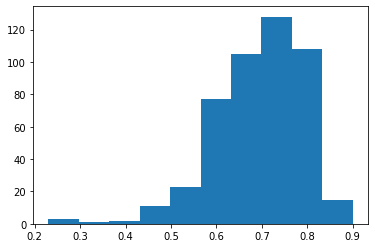

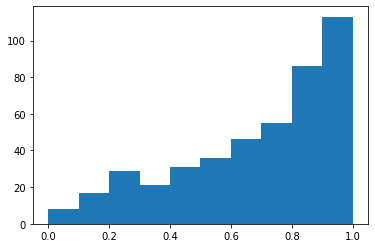

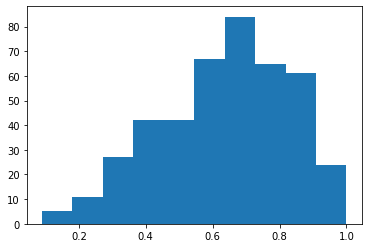

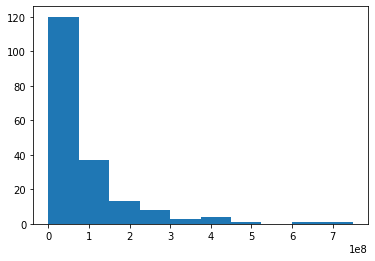

In [408]:
for i in df_scores1.iloc[:, 2:]:
    plt.figure()
    plt.hist(df_scores1[i])
    plt.show();

In [403]:
df_scores1.head(10)

,titles,info,IMDb_score,RT_score,Meta_score,box_office
0,10 Things I Hate About You,"{""Title"":""10 Things I Hate About You"",""Year"":""...",0.73,0.68,0.7,NaN
1,12,"{""Title"":""12"",""Year"":""2007"",""Rated"":""PG-13"",""R...",0.77,0.76,0.72,NaN
2,12 and Holding,"{""Title"":""12 and Holding"",""Year"":""2005"",""Rated...",0.75,0.73,0.65,NaN
3,12 Monkeys,"{""Title"":""12 Monkeys"",""Year"":""1995"",""Rated"":""R...",0.8,0.89,0.74,NaN
4,12 Years a Slave,"{""Title"":""12 Years a Slave"",""Year"":""2013"",""Rat...",0.81,0.95,0.96,50628650
5,127 Hours,"{""Title"":""127 Hours"",""Year"":""2010"",""Rated"":""R""...",0.76,0.93,0.82,18329466
6,1492: Conquest of Paradise,"{""Title"":""1492: Conquest of Paradise"",""Year"":""...",0.65,0.32,0.47,NaN
7,15 Minutes,"{""Title"":""15 Minutes"",""Year"":""2001"",""Rated"":""R...",0.61,0.32,0.34,24160216
8,17 Again,"{""Title"":""17 Again"",""Year"":""2009"",""Rated"":""PG-...",0.63,0.56,0.48,64087443
9,187,"{""Title"":""187"",""Year"":""2016"",""Rated"":""N/A"",""Re...",NaN,NaN,NaN,NaN


In [409]:
df_scores1.isna().sum()

titles          0
info            0
IMDb_score     27
RT_score       58
Meta_score     72
box_office    312
dtype: int64